In [ ]:
!pip install transformers

In [33]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from transformers import pipeline
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

C:\Users\Alexander\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [23]:
classifier("I love this!")

[[{'label': 'anger', 'score': 0.004419781267642975},
  {'label': 'disgust', 'score': 0.0016119900392368436},
  {'label': 'fear', 'score': 0.0004138521908316761},
  {'label': 'joy', 'score': 0.9771687984466553},
  {'label': 'neutral', 'score': 0.005764583125710487},
  {'label': 'sadness', 'score': 0.002092392183840275},
  {'label': 'surprise', 'score': 0.008528688922524452}]]

In [24]:
classifier(["I love this!", "I hate this!"])

[[{'label': 'anger', 'score': 0.004419781267642975},
  {'label': 'disgust', 'score': 0.0016119900392368436},
  {'label': 'fear', 'score': 0.0004138521908316761},
  {'label': 'joy', 'score': 0.9771687984466553},
  {'label': 'neutral', 'score': 0.005764583125710487},
  {'label': 'sadness', 'score': 0.002092392183840275},
  {'label': 'surprise', 'score': 0.008528688922524452}],
 [{'label': 'anger', 'score': 0.6189557909965515},
  {'label': 'disgust', 'score': 0.3279286026954651},
  {'label': 'fear', 'score': 0.004268052522093058},
  {'label': 'joy', 'score': 0.0026416887994855642},
  {'label': 'neutral', 'score': 0.014557044953107834},
  {'label': 'sadness', 'score': 0.025817139074206352},
  {'label': 'surprise', 'score': 0.005831680726259947}]]

In [25]:
text_test = pd.read_csv("./data/t2e/text_test.csv")
text_test.head()

,wav_file,label,transcription
0,Ses05M_script01_3_M018,4,i kissed you .
1,Ses01F_script03_1_M002,3,it must be them then .
2,Ses04M_script03_1_M001,3,i wonder .
3,Ses02F_script03_1_F000,3,do you think it s them ?
4,Ses02F_impro05_F006,0,that s all that s all that s all you re going ...


In [26]:
unique_texts = text_test["transcription"].unique().tolist()

In [27]:
preds = classifier(unique_texts)

In [39]:
list(zip(unique_texts, preds))[:2]

[('i kissed you .',
  [{'label': 'anger', 'score': 0.00429416261613369},
   {'label': 'disgust', 'score': 0.0006018253043293953},
   {'label': 'fear', 'score': 0.0014956137165427208},
   {'label': 'joy', 'score': 0.8674219846725464},
   {'label': 'neutral', 'score': 0.02878144383430481},
   {'label': 'sadness', 'score': 0.040796007961034775},
   {'label': 'surprise', 'score': 0.05660904943943024}]),
 ('it must be them then .',
  [{'label': 'anger', 'score': 0.01174916885793209},
   {'label': 'disgust', 'score': 0.00749609712511301},
   {'label': 'fear', 'score': 0.004031592048704624},
   {'label': 'joy', 'score': 0.006925765424966812},
   {'label': 'neutral', 'score': 0.8741339445114136},
   {'label': 'sadness', 'score': 0.012472460977733135},
   {'label': 'surprise', 'score': 0.08319094777107239}])]

In [74]:
results_df = pd.DataFrame(
    columns=["transcription", "pred", "anger", "disgust", "fear", "joy",
             "neutral", "sadness", "surprise"])

for text, pred in list(zip(unique_texts, preds)):
  pred_dict = {label_dict["label"]: label_dict["score"] for label_dict in pred}
  pred_dict["pred"] = list(pred_dict.keys())[np.argmax(list(pred_dict.values()))]
  pred_dict["transcription"] = text
  pred_df = pd.DataFrame(pred_dict, index=[0])
  results_df = pd.concat([results_df, pred_df]).reset_index(drop=True)

In [75]:
results_df.head()

,transcription,pred,anger,disgust,fear,joy,neutral,sadness,surprise
0,i kissed you .,joy,0.004294,0.000602,0.001496,0.867422,0.028781,0.040796,0.056609
1,it must be them then .,neutral,0.011749,0.007496,0.004032,0.006926,0.874134,0.012472,0.083191
2,i wonder .,surprise,0.002950,0.000581,0.005135,0.004922,0.011466,0.016120,0.958826
3,do you think it s them ?,neutral,0.025332,0.010591,0.008360,0.004837,0.488408,0.010772,0.451699
4,that s all that s all that s all you re going ...,joy,0.070038,0.007763,0.003606,0.453828,0.364092,0.040638,0.060035


In [76]:
results_df.to_csv("./data/bert_results/results.csv")

In [78]:
preds_df = text_test.merge(results_df, how="left", on="transcription")

In [79]:
preds_df.to_csv("./data/bert_results/preds.csv")

In [57]:
preds_df = pd.read_csv("./data/bert_results/preds.csv", index_col=0)

In [58]:
preds_df.head()

,wav_file,label,transcription,pred,anger,disgust,fear,joy,neutral,sadness,surprise
0,Ses05M_script01_3_M018,4,i kissed you .,joy,0.004294,0.000602,0.001496,0.867422,0.028781,0.040796,0.056609
1,Ses01F_script03_1_M002,3,it must be them then .,neutral,0.011749,0.007496,0.004032,0.006926,0.874134,0.012472,0.083191
2,Ses04M_script03_1_M001,3,i wonder .,surprise,0.002950,0.000581,0.005135,0.004922,0.011466,0.016120,0.958826
3,Ses02F_script03_1_F000,3,do you think it s them ?,neutral,0.025332,0.010591,0.008360,0.004837,0.488408,0.010772,0.451699
4,Ses02F_impro05_F006,0,that s all that s all that s all you re going ...,joy,0.070038,0.007763,0.003606,0.453828,0.364092,0.040638,0.060035


In [60]:
emotion_list = ["anger", "joy", "sadness", "fear", "surprise", "neutral"]
preds_df.loc[preds_df["pred"] == "disgust", "pred"] = "anger"
preds_df["anger"] = preds_df["anger"] + preds_df["disgust"]
preds_df = preds_df.drop("disgust", 1)
preds_df["pred_probas"] = preds_df.apply(lambda x: [x[prob] for prob in emotion_list], axis=1)

In [61]:
preds_df.head()

,wav_file,label,transcription,pred,anger,fear,joy,neutral,sadness,surprise,pred_probas
0,Ses05M_script01_3_M018,4,i kissed you .,joy,0.004896,0.001496,0.867422,0.028781,0.040796,0.056609,"[0.0048959879204628996, 0.8674219846725464, 0...."
1,Ses01F_script03_1_M002,3,it must be them then .,neutral,0.019245,0.004032,0.006926,0.874134,0.012472,0.083191,"[0.019245265983045, 0.0069257654249668, 0.0124..."
2,Ses04M_script03_1_M001,3,i wonder .,surprise,0.003531,0.005135,0.004922,0.011466,0.016120,0.958826,"[0.0035309633822179, 0.0049220849759876, 0.016..."
3,Ses02F_script03_1_F000,3,do you think it s them ?,neutral,0.035924,0.008360,0.004837,0.488408,0.010772,0.451699,"[0.0359236719086765, 0.004836578387767, 0.0107..."
4,Ses02F_impro05_F006,0,that s all that s all that s all you re going ...,joy,0.077801,0.003606,0.453828,0.364092,0.040638,0.060035,"[0.0778008392080663, 0.4538281261920929, 0.040..."


In [80]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    print(num_records)
    temp = np.array(true_labels[:num_records])
    print(temp)
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    print(classification_report(y_test, pred, target_names=emo_keys))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.200
Test Set F-score =  0.217
Test Set Precision =  0.316
Test Set Recall =  0.316
              precision    recall  f1-score   support

         ang       0.17      0.23      0.20       241
         hap       0.32      0.25      0.28       360
         sad       0.29      0.20      0.23       633
         fea       0.74      0.05      0.09      8972
         sur       0.34      0.62      0.44      2898
         neu       0.03      0.55      0.06       402

    accuracy                           0.20     13506
   macro avg       0.32      0.32      0.22     13506
weighted avg       0.59      0.20      0.18     13506

Confusion matrix, without normalization
[[  56   18   27    9   60   71]
 [  20   89   24   23   97  107]
 [  42   47  124   37  102  281]
 [   0    0  172  407 3109 5284]
 [ 189  104   40   40 1797  728]
 [  17   23   45   33   61  223]]


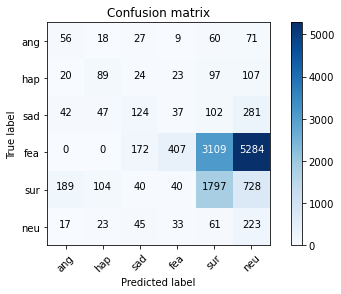

In [68]:
pred_probas = np.array(preds_df["pred_probas"].tolist())
with open('pred_probas/distilroberta_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probas, f)
display_results(preds_df["label"], pred_probas)